In [39]:
import os
import shutil
import math

import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [42]:
# # Organize data into training and test datasets

data_dir = './dataset'
test_files = []

for x in range(10): # Loop 10 times for each class
    # split images into 8:2
    files = os.listdir(data_dir + "/" + str(x))
    train_files = files[:int(len(files)*0.8)]
    
    train_files_new = [None] * len(train_files)
    path = "./dataset/train" + str(int(x/2)) +  "/" + str(x)
    
    # Create directory if not created
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)
        
    # copy to new path
    for y in range(len(train_files)):
        print(data_dir + "/" + str(x) + "/" + train_files[y])
        shutil.copyfile(data_dir + "/" + str(x) + "/" + train_files[y], path + "/" + train_files[y])
    
        
    # same but for test images
    test_files = files[int(len(files)*0.8):len(files)]
    test_files_new = [None] * int(len(test_files)/5)
    
    for y in range(5): # Loop for each dataset
        test_file_dataset = test_files[y*int(len(test_files)/5):(y+1)*int(len(test_files)/5)]
        path = "./dataset/test" + str(y) + "/" + str(x)
        
        # Create directory if not created
        isExist = os.path.exists(path)
        if not isExist:
            os.makedirs(path)
            
        for z in range(len(test_file_dataset)):
            print(data_dir + "/" + str(x) + "/" + test_files[y])
            shutil.copyfile(data_dir + "/" + str(x) + "/" + test_files[z], path + "/" + test_files[z])

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
./dataset/9/46011.jpg
./dataset/9/7998.jpg
./dataset/9/31827.jpg
./dataset/9/3819.jpg
./dataset/9/16095.jpg
./dataset/9/39866.jpg
./dataset/9/2275.jpg
./dataset/9/35126.jpg
./dataset/9/26777.jpg
./dataset/9/26621.jpg
./dataset/9/46035.jpg
./dataset/9/5392.jpg
./dataset/9/19310.jpg
./dataset/9/47568.jpg
./dataset/9/30374.jpg
./dataset/9/7459.jpg
./dataset/9/48649.jpg
./dataset/9/17896.jpg
./dataset/9/38168.jpg
./dataset/9/4748.jpg
./dataset/9/16525.jpg
./dataset/9/35735.jpg
./dataset/9/41632.jpg
./dataset/9/40085.jpg
./dataset/9/4632.jpg
./dataset/9/22332.jpg
./dataset/9/3180.jpg
./dataset/9/17510.jpg
./dataset/9/26217.jpg
./dataset/9/8402.jpg
./dataset/9/45391.jpg
./dataset/9/2338.jpg
./dataset/9/21190.jpg
./dataset/9/14274.jpg
./dataset/9/10025.jpg
./dataset/9/17256.jpg
./dataset/9/39912.jpg
./dataset/9/39814.jpg
./dataset/9/11800.jpg
./dataset/9/1032.jpg
./dataset/9/33370.jpg
./dataset/9/9229.jpg
./dataset/9/15503.jpg
./dataset/9/33911.jpg
./datase

##### Check if training dataset is correctly created

In [43]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

train_dataset = [None] * 5
test_dataset = [None] * 5
for x in range(5):
    train_dataset[x] = ImageFolder(data_dir+'/train'+str(x), transform=ToTensor())
    test_dataset[x] = ImageFolder(data_dir+'/test'+str(x), transform=ToTensor())

In [44]:
img, label = train_dataset[0][0]
print(img.shape, label)
img, label = test_dataset[0][0]
print(img.shape, label)

torch.Size([3, 32, 32]) 0
torch.Size([3, 32, 32]) 0


In [45]:
print(train_dataset[0].classes)
print(test_dataset[0].classes)

['0', '1']
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [46]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

def show_example(img, label):
    print('Label: ', train_dataset[0].classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  0 (0)


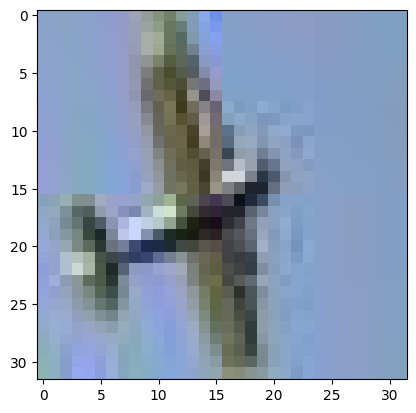

In [47]:
show_example(*train_dataset[0][0])

Label:  0 (0)


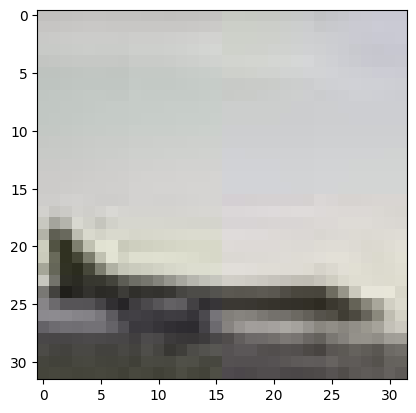

In [48]:
show_example(*test_dataset[0][0])

##### Create validation set 

In [49]:
# Set seed to always create the same validation set
import torch

torch.manual_seed(10)

val_size_ratio = 0.1
val_size = int(len(train_dataset[0]) * val_size_ratio)
val_dataset = [None] * 5

for x in range(5):
    train_size = len(train_dataset[x]) - val_size

    train_dataset[x], val_dataset[x] = random_split(train_dataset[x], [train_size, val_size])
    print(len(train_dataset[x]), len(val_dataset[x]))

7200 800
7200 800
7200 800
7200 800
7200 800


##### Create dataloader object

In [50]:
from torch.utils.data.dataloader import DataLoader

batch_size=4

train_dataload = [None]*5
test_dataload = [None]*5
val_dataload = [None]*5
for x in range(5):
    train_dataload[x] = DataLoader(train_dataset[x], batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_dataload[x] = DataLoader(test_dataset[x], batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_dataload[x] = DataLoader(val_dataset[x], batch_size, num_workers=2, pin_memory=True)

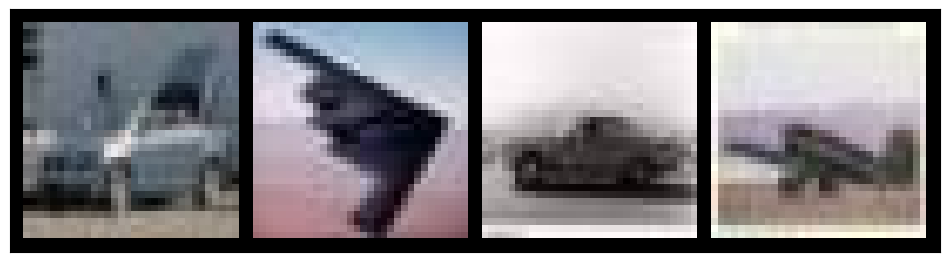

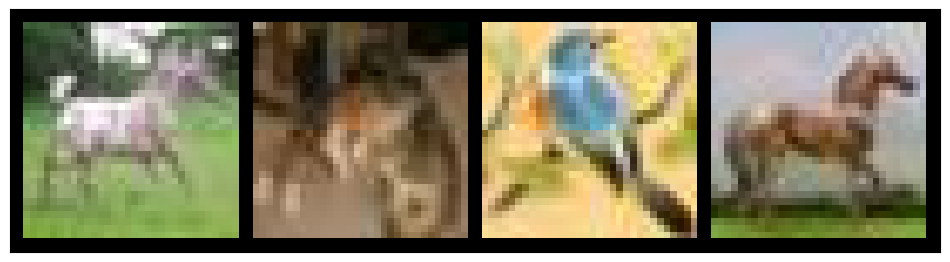

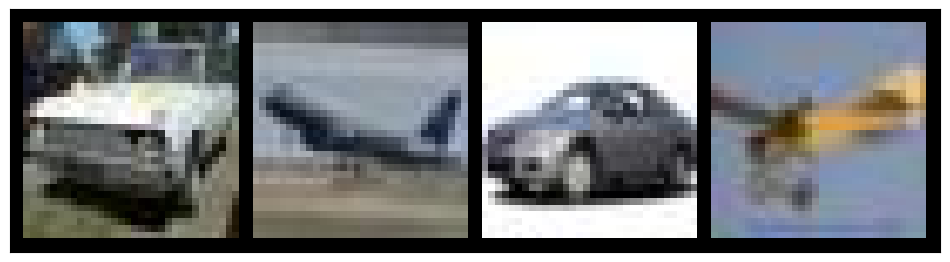

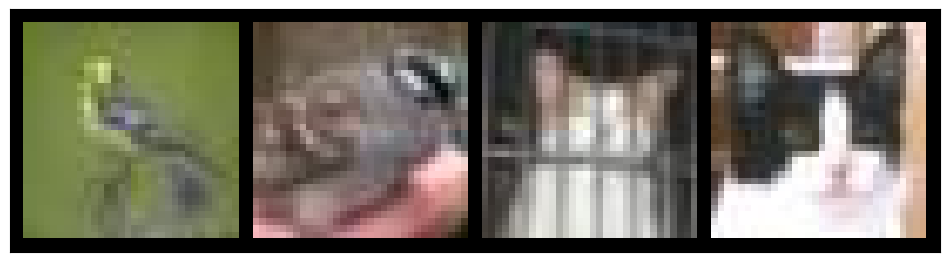

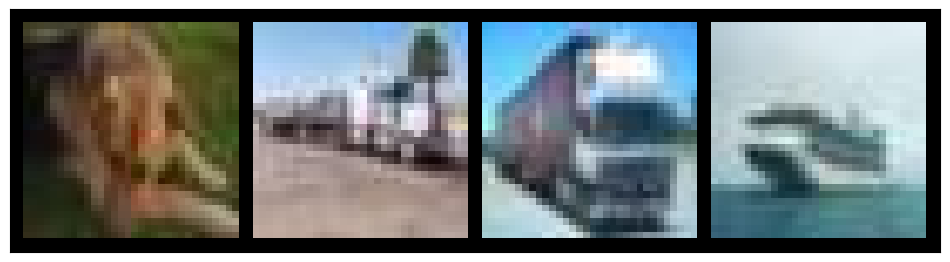

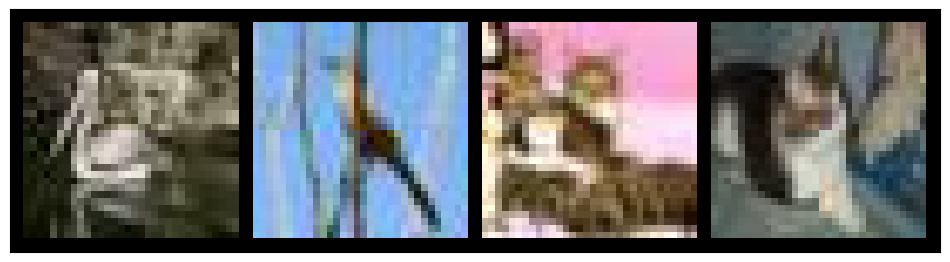

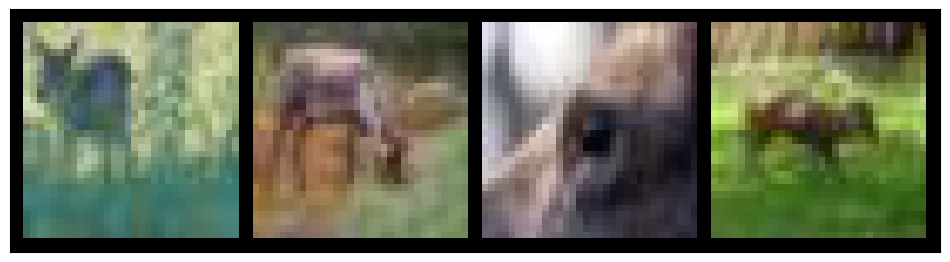

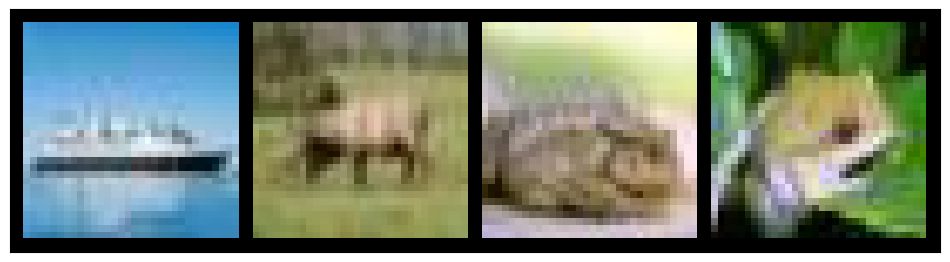

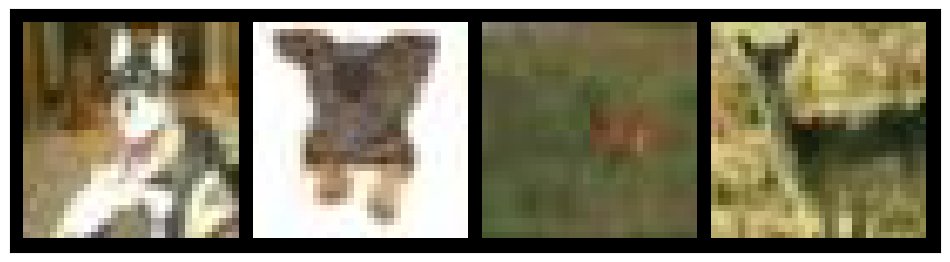

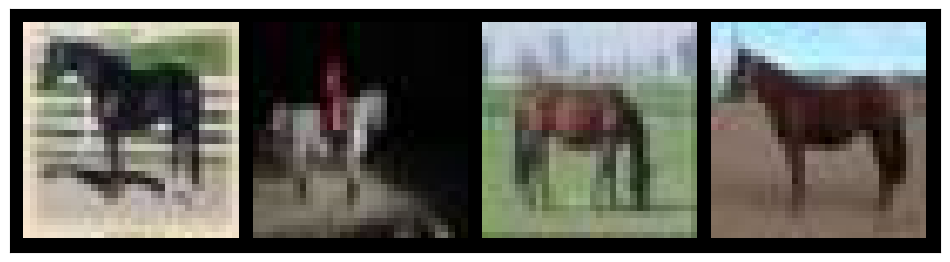

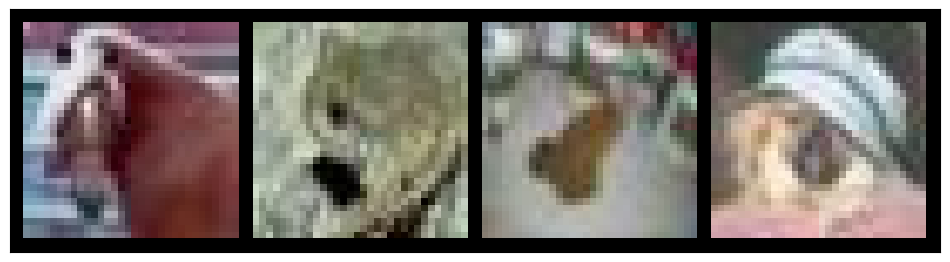

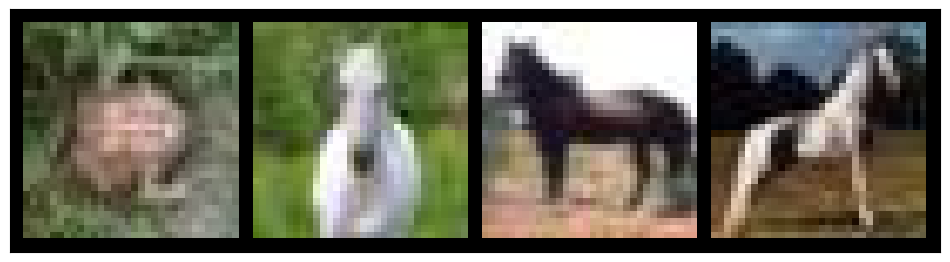

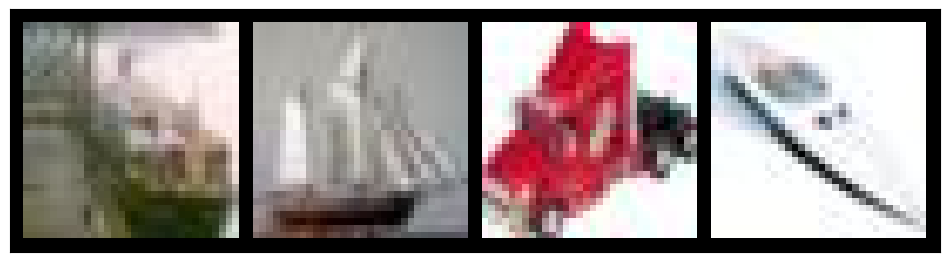

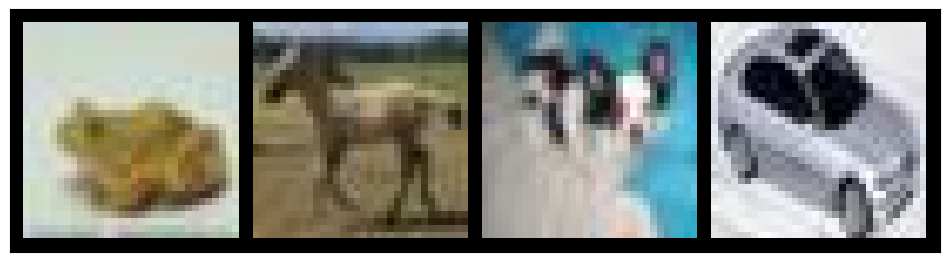

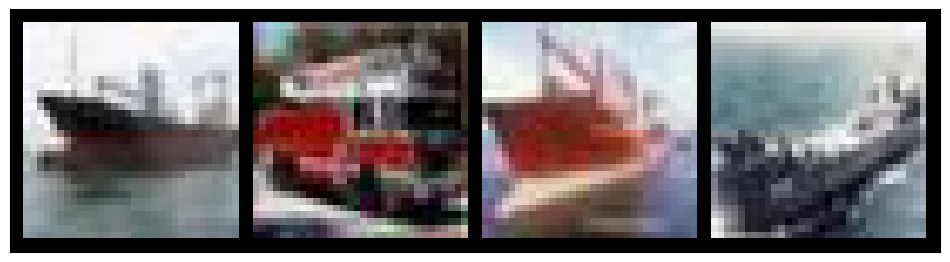

In [51]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

for x in range(5):
    show_batch(train_dataload[x])
    show_batch(test_dataload[x])
    show_batch(val_dataload[x])

In [52]:
# define CNN

import torch.nn as nn
import torch
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=False),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Linear(32*16*16, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 10)
            
    def forward(self, x):
        x = self.conv(x)

        x = x.view(-1, 32*16*16)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        x = torch.relu(x)
        x = self.fc5(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
cnn = CNN()
# Set device to GPU
cnn.to(device)

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=8192, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=32, bias=True)
  (fc5): Linear(in_features=32, out_features=10, bias=True)
)

In [53]:
# Define loss function and optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

##### Train network

In [54]:
# Train network

def train(dataset_no):
    running_loss = 0.0
    for epoch in range(2):  # loop over the dataset multiple times
        for i, data in enumerate(train_dataload[dataset_no], 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)


            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 0:    # print every batch size
                print(f'[{dataset_no}, {epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
            # Save model
    PATH = './CNN_model'
    torch.save(cnn.state_dict(), PATH)
    
    print('Finished Training dataset: ' + str(dataset_no))

In [55]:
def test(dataset_no): 
  # Test images

  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in test_dataload[dataset_no]:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          # calculate outputs by running images through the network
          outputs = cnn(inputs)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [56]:
for x in range(5):
    train(x)
    test(x)

[0, 1,     1] loss: 0.001
[0, 1,   101] loss: 0.074
[0, 1,   201] loss: 0.034
[0, 1,   301] loss: 0.031
[0, 1,   401] loss: 0.020
[0, 1,   501] loss: 0.022
[0, 1,   601] loss: 0.018
[0, 1,   701] loss: 0.021
[0, 1,   801] loss: 0.016
[0, 1,   901] loss: 0.018
[0, 1,  1001] loss: 0.017
[0, 1,  1101] loss: 0.017
[0, 1,  1201] loss: 0.016
[0, 1,  1301] loss: 0.016
[0, 1,  1401] loss: 0.016
[0, 1,  1501] loss: 0.015
[0, 1,  1601] loss: 0.015
[0, 1,  1701] loss: 0.014
[0, 2,     1] loss: 0.015
[0, 2,   101] loss: 0.014
[0, 2,   201] loss: 0.013
[0, 2,   301] loss: 0.014
[0, 2,   401] loss: 0.011
[0, 2,   501] loss: 0.011
[0, 2,   601] loss: 0.013
[0, 2,   701] loss: 0.012
[0, 2,   801] loss: 0.011
[0, 2,   901] loss: 0.011
[0, 2,  1001] loss: 0.012
[0, 2,  1101] loss: 0.011
[0, 2,  1201] loss: 0.009
[0, 2,  1301] loss: 0.011
[0, 2,  1401] loss: 0.008
[0, 2,  1501] loss: 0.012
[0, 2,  1601] loss: 0.010
[0, 2,  1701] loss: 0.011
Finished Training dataset: 0
Accuracy of the network on the test

Exception in thread Thread-82 (_pin_memory_loop):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/pin_memory.py", line 51, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/pin_memory.py", line 28, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.10/dist-packages/torch/multiprocessing/reductions.py", line 307, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.10/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3

KeyboardInterrupt: ignored

ValueError: ignored